In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import core.config as config
from core.model_loader import load_pretrained_VAE, load_pretrained_GLOW
from core.data_loader import TRAIN_loader, TEST_loader
from core.custom_loss import KL_div, VAE_loss
from core.fisher_utils_VAE import Calculate_fisher_VAE, Calculate_score_VAE
from core.fisher_utils_VAE import AUTO_VAE_CIFAR, AUTO_VAE_FMNIST
from core.fisher_utils_GLOW import Calculate_fisher_GLOW, Calculate_score_GLOW
from core.fisher_utils_GLOW import AUTO_GLOW_CIFAR, AUTO_GLOW_FMNIST
from core.visualize import plot_hist, AUROC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Global Variables & Initialize

In [32]:
# FISHER_invs : Fisher inverse matrices from calculating Fisher score (w.r.t. train-dist)
FISHERs = {'VAE': {'cifar10': 0, 'fmnist': 0},
           'GLOW': {'cifar10': 0, 'fmnist': 0}}
         
# NORMalize_FACtors : Normalizing Factor (w.r.t. train-dist)
NORM_FACs = {'VAE': {'cifar10': 0, 'fmnist': 0},
             'GLOW': {'cifar10': 0, 'fmnist': 0}}
             
# SCOREs : (Scalars) Scores from calculating Fisher score (w.r.t. target-dist)
SCOREs = {'VAE': {'cifar10': {}, 'fmnist': {}},
          'GLOW': {'cifar10': {}, 'fmnist': {}}}

## Note

dictionary 형태로 결괏값을 저장합니다.   
key의 형태는 model - in-dist - out-dist 입니다.  
(ex)  
FISHERs['VAE']['cifar10'] : VAE모델, cifar10훈련 시 나온 Fisher Inverse matrix
NORM_FACs['VAE']['cifar10'] : VAE모델, cifar10훈련 시 나온 Normalize_Factor  
SCOREs['VAE']['cifar10']['svhn'] : VAE모델, cifar10 (In), svhn (Out) 시 score  

# VAE-CIFAR10

In [60]:
train_dist = 'cifar10'
opt = config.VAE_cifar10
netE, netG = load_pretrained_VAE(option=train_dist, ngf=64, nz=100, beta=1)

dicts = [netE.conv1.weight]
#dicts = [netE.conv1.weight, netG.main[-1].weight,]

In [61]:
a, b, _scores = AUTO_VAE_CIFAR(netE, netG, dicts, max_iter=[1000, 500], loss_type='ELBO')

Files already downloaded and verified


Calculate Fisher VAE:   2%|█                                                     | 999/50000 [00:14<12:04, 67.59step/s]


Files already downloaded and verified


Calculate Score VAE:   5%|██▋                                                    | 499/10000 [00:06<01:58, 80.16step/s]


Using downloaded and verified file: ../data\test_32x32.mat


Calculate Score VAE:   5%|██▋                                                   | 499/10000 [00:04<01:25, 110.64step/s]


In [62]:
FISHERs['VAE']['cifar10'] = a[dicts[0]]
NORM_FACs['VAE']['cifar10'] = b[dicts[0]]
for ood in ['cifar10', 'svhn', 'celeba', 'lsun', 'noise']:
    SCOREs['VAE']['cifar10'][ood] = _scores[ood][dicts[0]]

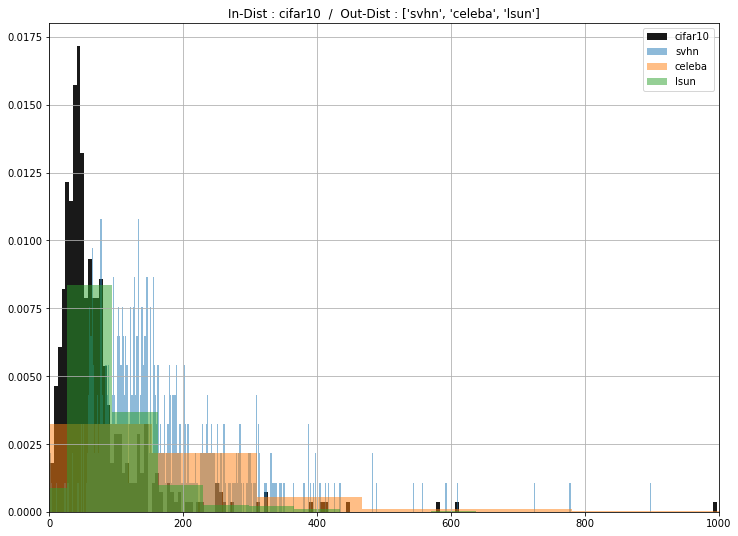

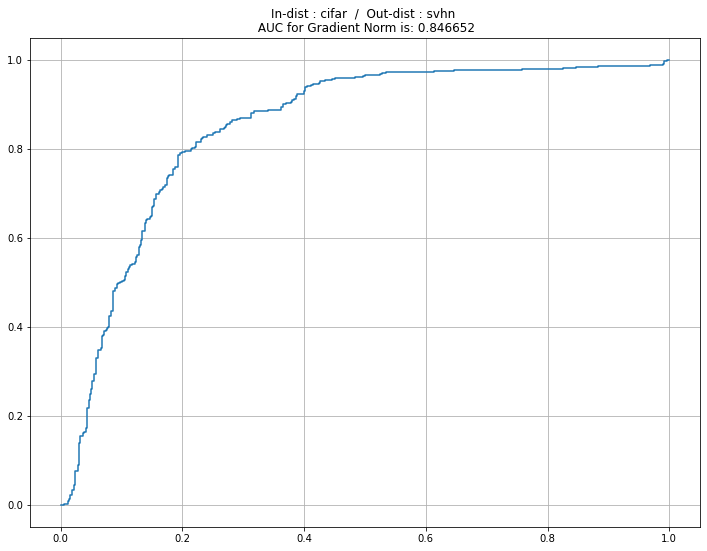

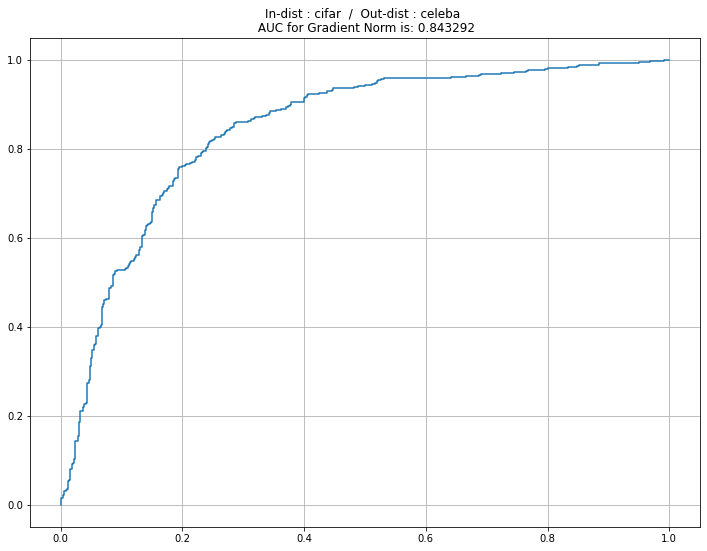

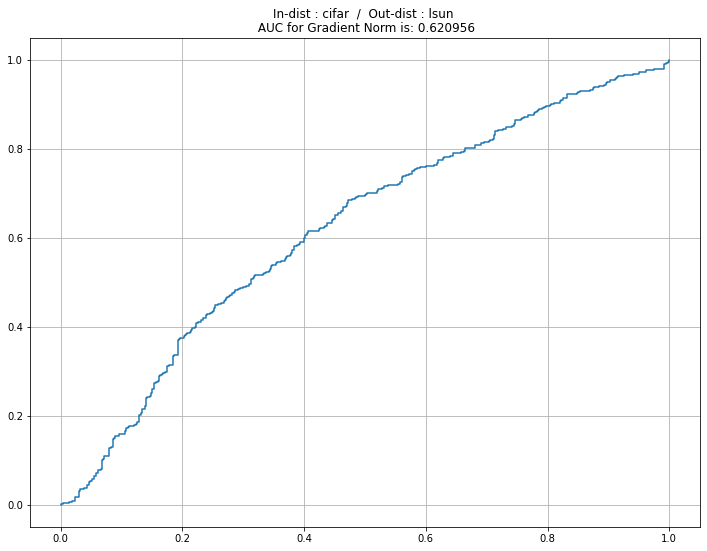

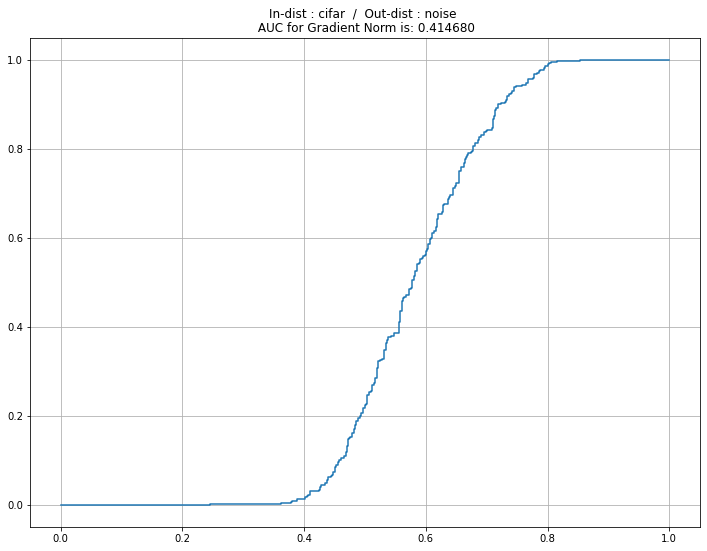

In [65]:
# Histogram
args = [
    SCOREs['VAE']['cifar10']['cifar10'],
    SCOREs['VAE']['cifar10']['svhn'],
    SCOREs['VAE']['cifar10']['celeba'],
    SCOREs['VAE']['cifar10']['lsun'],
]
bins = [3000, 1000, 3000, 3000]
labels = ['cifar10', 'svhn', 'celeba', 'lsun']
xlim = [0, 1000]
plot_hist(*args, bins=bins, labels=labels, xlim=xlim)


# AUROC curve
for ood in ['svhn', 'celeba', 'lsun', 'noise']:
    args = [
        SCOREs['VAE']['cifar10']['cifar10'],
        SCOREs['VAE']['cifar10'][ood],
    ]
    labels = ['cifar', ood]
    AUROC(*args, labels=labels)

# VAE-FMNIST

In [46]:
train_dist = 'fmnist'
opt = config.VAE_fmnist
netE, netG = load_pretrained_VAE(option=train_dist, ngf=64, nz=100, beta=1)

#dicts = [netG.main[-1].weight, netE.conv1.weight]
dicts = [netE.conv1.weight]

In [56]:
a, b, _scores = AUTO_VAE_FMNIST(netE, netG, dicts, max_iter=[1000, 500], loss_type='ELBO')

Calculate Score VAE:   5%|██▋                                                   | 499/10000 [00:03<01:11, 132.42step/s]


In [57]:
FISHERs['VAE']['fmnist'] = a[dicts[0]]
NORM_FACs['VAE']['fmnist'] = b[dicts[0]]
for ood in ['fmnist', 'mnist', 'noise']:
    SCOREs['VAE']['fmnist'][ood] = _scores[ood][dicts[0]]

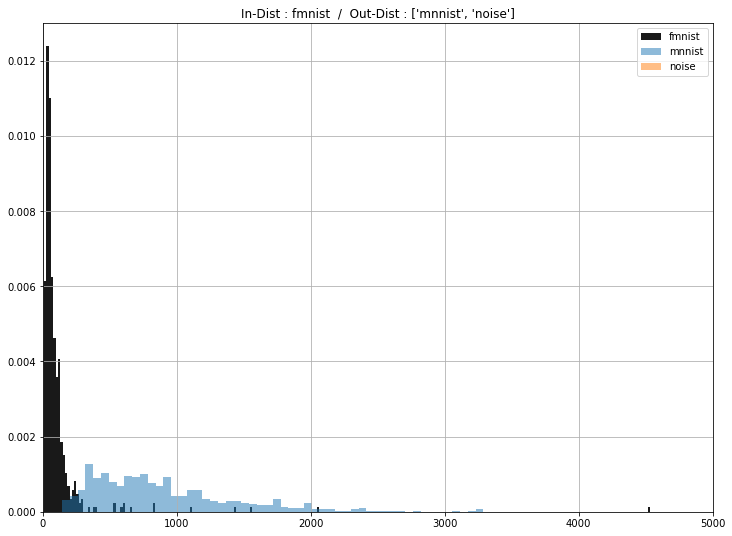

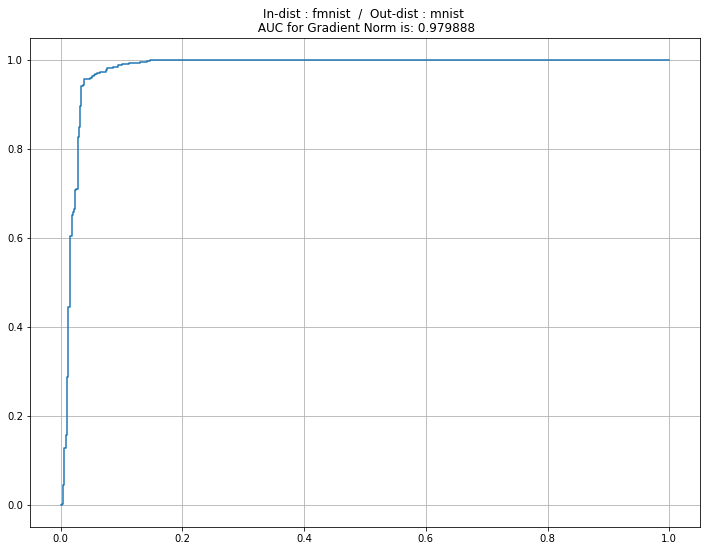

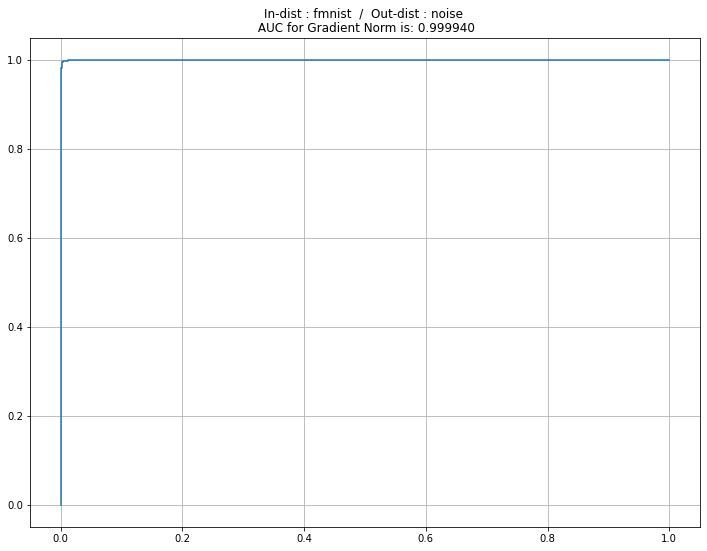

In [59]:
# Histogram
args = [
    SCOREs['VAE']['fmnist']['fmnist'],
    SCOREs['VAE']['fmnist']['mnist'],
    SCOREs['VAE']['fmnist']['noise'],
]
bins = [1000, 100, 100]
labels = ['fmnist', 'mnnist', 'noise']
xlim = [0, 5000]
plot_hist(*args, bins=bins, labels=labels, xlim=xlim)


# AUROC curve
for ood in ['mnist', 'noise']:
    args = [
        SCOREs['VAE']['fmnist']['fmnist'],
        SCOREs['VAE']['fmnist'][ood],
    ]
    labels = ['fmnist', ood]
    AUROC(*args, labels=labels)

# GLOW-CIFAR10

In [160]:
train_dist = 'cifar10'
opt = config.GLOW_cifar10
model = load_pretrained_GLOW(option=train_dist)

dicts = [model.flow.layers[-1]]

In [161]:
a, b, c, d, e, f, g = AUTO_GLOW_CIFAR(model, dicts)
GRADs['GLOW']['cifar10'] = a
NORM_FACs['GLOW']['cifar10'] = b
Gradients['GLOW']['cifar10']['cifar10'] = c
Gradients['GLOW']['cifar10']['svhn'] = d
Gradients['GLOW']['cifar10']['celeba'] = e
Gradients['GLOW']['cifar10']['lsun'] = f
Gradients['GLOW']['cifar10']['noise'] = g

Files already downloaded and verified


Calculate Fisher GLOW:   2%|█                                                 | 1001/50000 [04:28<3:38:56,  3.73step/s]


Files already downloaded and verified


Calculate Score GLOW:   4%|██▏                                                   | 401/10000 [01:48<43:22,  3.69step/s]


Using downloaded and verified file: ../data/test_32x32.mat


Calculate Score GLOW:   4%|██▏                                                   | 401/10000 [01:46<42:33,  3.76step/s]


In [12]:
# Histogram
args = [
    Gradients['GLOW']['cifar10']['cifar10'],
    Gradients['GLOW']['cifar10']['svhn'],
    Gradients['GLOW']['cifar10']['celeba'],
    Gradients['GLOW']['cifar10']['lsun'],
    Gradients['GLOW']['cifar10']['noise'],
]
bins = [100, 100, 100, 100, 100]
labels = ['cifar10', 'svhn', 'celeba', 'lsun', 'noise']
xlim = [0, 2]
plot_hist(*args, bins=bins, labels=labels, xlim=xlim)


# AUROC curve
args = [
    Gradients['GLOW']['cifar10']['cifar10'],
    Gradients['GLOW']['cifar10']['svhn'],
]
labels = ['cifar', 'svhn']
AUROC(*args, labels=labels)

KeyError: 'cifar10'

# GLOW-FMNIST (미완성)

In [ ]:
train_dist = 'fmnist'
opt = config.GLOW_fmnist # 에러날 거
netE, netG = load_pretrained_VAE(option=train_dist)

dicts = [netG.main[-1].weight, netE.conv1.weight]

In [ ]:
a, b, c, d, e = AUTO_GLOW_FNNIST(netE, netG, dicts)
GRADs['GLOW']['fmnist'] = a
NORM_FACs['GLOW']['fmnist'] = b
Gradients['GLOW']['fmnist']['fmnist'] = c
Gradients['GLOW']['fmnist']['mnist'] = d
Gradients['GLOW']['fmnist']['noise'] = e

In [ ]:
# Histogram
args = [
    Gradients['GLOW']['fmnist']['fmnist'],
    Gradients['GLOW']['fmnist']['mnist'],
    Gradients['GLOW']['fmnist']['noise'],
]
bins = [100, 100, 100]
labels = ['fmnist', 'mnnist', 'noise']
xlim = [0, 5]
plot_hist(*args, bins=bins, labels=labels, xlim=xlim)


# AUROC curve
args = [
    Gradients['GLOW']['fmnist']['fmnist'],
    Gradients['GLOW']['fmnist']['mnist'],
]
labels = ['fmnist', 'mnist']
AUROC(*args, labels=labels)